Importing relevant modules and libraries

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import graphviz

from IPython.display import display
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import LinearSVC, SVC # Import SVC here
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier, export_graphviz

# Import GridSearchCV and accuracy_score if not already imported
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score

In [2]:
nba_df = pd.read_csv('/content/nba_stats.csv')
print("nba_df.columns:", nba_df.columns.tolist())

nba_df.columns: ['Pos', 'Age', 'G', 'GS', 'MP', 'FG', 'FGA', 'FG%', '3P', '3PA', '3P%', '2P', '2PA', '2P%', 'eFG%', 'FT', 'FTA', 'FT%', 'ORB', 'DRB', 'TRB', 'AST', 'STL', 'BLK', 'TOV', 'PF', 'PTS']


The data set consists of 874 data points with 27 features each.

In [3]:
print("Shape of NBA data: {}".format(nba_df.shape))


Shape of NBA data: (874, 27)


In [4]:
print("Sample counts per class:\n{}".format(nba_df['Pos'].value_counts().to_dict()))

Sample counts per class:
{'SG': 196, 'PF': 186, 'PG': 172, 'C': 161, 'SF': 159}


In [5]:
import pandas as pd
import numpy as np

# Loading the data
df = pd.read_csv('/content/nba_stats.csv')

# Removing non-predictive columns
cols_to_drop = ['Player', 'Rk', 'Tm']
df = df.drop(columns=[col for col in cols_to_drop if col in df.columns], errors='ignore')

# Dropping redundant percentage columns
perc_cols = ['FG%', '3P%', '2P%', 'FT%', 'eFG%']
df = df.drop(columns=[col for col in perc_cols if col in df.columns], errors='ignore')

# Filtering to only valid positions
VALID_POS = ['PG', 'SG', 'SF', 'PF', 'C']
df = df[df['Pos'].isin(VALID_POS)]

# Setting playing time threshold
df = df[(df['MP'] >= 15) & (df['G'] >= 20)]

# Dealing with missing values
num_cols = df.select_dtypes(include=[np.number]).columns
df[num_cols] = df[num_cols].apply(lambda x: x.fillna(x.median()))


df = df.dropna(subset=['Pos'])


df = df.reset_index(drop=True)


print(f"Cleaned NBA stats shape: {df.shape}")


Cleaned NBA stats shape: (490, 22)


TASK 1

Best k: 11
Training accuracy: 0.6148
Validation accuracy: 0.6327
Training Confusion Matrix:
 [[48 14  0  3  2]
 [14 45  1 13  5]
 [ 0  0 61  8 13]
 [ 1 17 11 32 15]
 [ 0  4 20 10 55]]
Validation Confusion Matrix:
 [[13  4  0  0  0]
 [ 2 12  0  4  1]
 [ 1  1 16  1  2]
 [ 0  3  1 10  5]
 [ 0  0  3  8 11]]


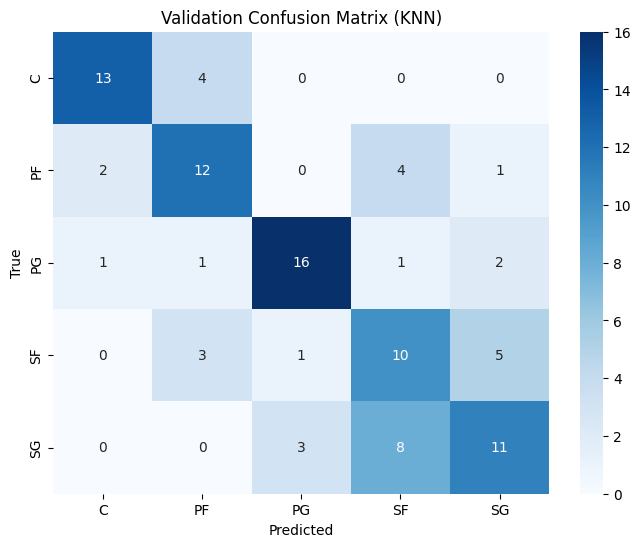

In [6]:
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

# Assuming df is the preprocessed DataFrame and 'Pos' is the target
X = df.drop(columns=['Pos'])
y = df['Pos']

# Standardization
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Splitting into training (80%) and validation (20%)
X_train, X_val, y_train, y_val = train_test_split(X_scaled, y, test_size=0.2, stratify=y, random_state=0)

# Hyperparameter tuning for 'n_neighbors'
param_grid = {'n_neighbors': range(3, 16)}
knn = KNeighborsClassifier()

grid = GridSearchCV(knn, param_grid, cv=5)
grid.fit(X_train, y_train)

# Best model
best_knn = grid.best_estimator_
print(f"Best k: {grid.best_params_['n_neighbors']}")

# Training and validation predictions
y_train_pred = best_knn.predict(X_train)
y_val_pred = best_knn.predict(X_val)

# Accuracy
print("Training accuracy: {:.4f}".format(accuracy_score(y_train, y_train_pred)))
print("Validation accuracy: {:.4f}".format(accuracy_score(y_val, y_val_pred)))

# Confusion matrices
train_cm = confusion_matrix(y_train, y_train_pred, labels=best_knn.classes_)
val_cm = confusion_matrix(y_val, y_val_pred, labels=best_knn.classes_)

print("Training Confusion Matrix:\n", train_cm)
print("Validation Confusion Matrix:\n", val_cm)

plt.figure(figsize=(8,6))
sns.heatmap(val_cm, annot=True, fmt='d',
            xticklabels=best_knn.classes_,
            yticklabels=best_knn.classes_,
            cmap='Blues')
plt.title("Validation Confusion Matrix (KNN)")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.show()


Best C: 1
Training accuracy: 0.6582
Validation accuracy: 0.5918
Training Confusion Matrix:
 [[62  5  0  0  0]
 [24 29  2 13 10]
 [ 0  0 78  1  3]
 [ 3  9  6 31 27]
 [ 0  6 18  7 58]]
Validation Confusion Matrix:
 [[15  2  0  0  0]
 [ 8  6  0  4  1]
 [ 1  1 17  0  2]
 [ 0  3  2  5  9]
 [ 0  1  4  2 15]]


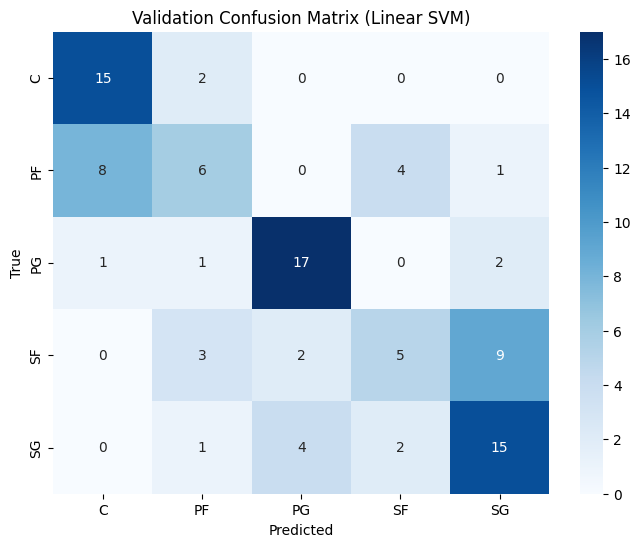

In [7]:
from sklearn.svm import LinearSVC
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import seaborn as sns


X = df.drop(columns=['Pos'])
y = df['Pos']

# Standardization is important for SVMs
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Training/validation split (80/20)
X_train, X_val, y_train, y_val = train_test_split(X_scaled, y, test_size=0.2, random_state=0, stratify=y)

# Hyperparameter tuning (regularization parameter C)
param_grid = {'C': [0.01, 0.05, 0.1, 0.5, 1, 2, 5, 10]}
svm = LinearSVC(random_state=0, max_iter=10000)

grid = GridSearchCV(svm, param_grid, cv=5)
grid.fit(X_train, y_train)

# Best model
best_svm = grid.best_estimator_
print("Best C:", grid.best_params_['C'])

# Training and validation predictions
y_train_pred = best_svm.predict(X_train)
y_val_pred = best_svm.predict(X_val)

# Accuracy
print("Training accuracy: {:.4f}".format(accuracy_score(y_train, y_train_pred)))
print("Validation accuracy: {:.4f}".format(accuracy_score(y_val, y_val_pred)))

# Confusion matrices
train_cm = confusion_matrix(y_train, y_train_pred, labels=best_svm.classes_)
val_cm = confusion_matrix(y_val, y_val_pred, labels=best_svm.classes_)

print("Training Confusion Matrix:\n", train_cm)
print("Validation Confusion Matrix:\n", val_cm)

# Optional: plot the validation confusion matrix
plt.figure(figsize=(8,6))
sns.heatmap(val_cm, annot=True, fmt='d', xticklabels=best_svm.classes_, yticklabels=best_svm.classes_, cmap='Blues')
plt.title("Validation Confusion Matrix (Linear SVM)")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.show()


Training accuracy: 0.500
Validation accuracy: 0.510
Training Confusion Matrix:
 [[48 14  0  4  1]
 [20 19  2 25 12]
 [ 0  2 38  2 40]
 [ 1 12  7 29 27]
 [ 0  2 15 10 62]]
Validation Confusion Matrix:
 [[14  1  0  2  0]
 [ 3  7  0  9  0]
 [ 1  1  7  3  9]
 [ 0  2  2  8  7]
 [ 0  0  3  5 14]]


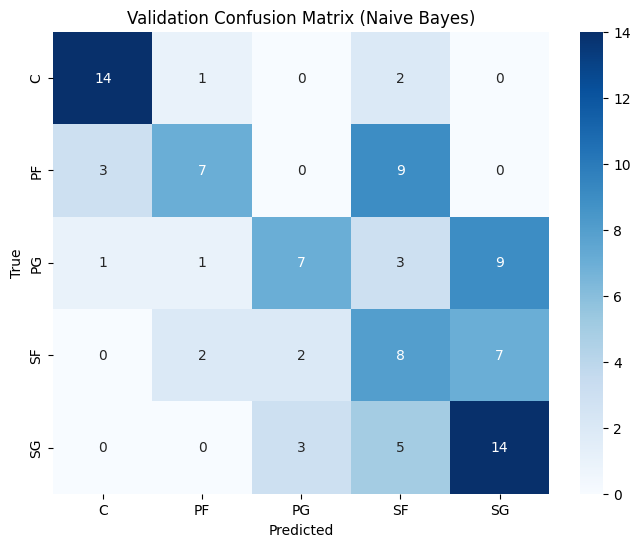

In [8]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import accuracy_score, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

# Assuming df is your preprocessed DataFrame and 'Pos' is the target column
X = df.drop(columns=['Pos'])
y = df['Pos']

# Standardization (Naive Bayes often works better with standardized features)
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Train/validation split
X_train, X_val, y_train, y_val = train_test_split(X_scaled, y, test_size=0.2, stratify=y, random_state=0)

# Instantiate and fit Gaussian Naive Bayes
nb = GaussianNB()
nb.fit(X_train, y_train)

# Predictions
y_train_pred = nb.predict(X_train)
y_val_pred = nb.predict(X_val)

# Accuracies
print("Training accuracy: {:.3f}".format(accuracy_score(y_train, y_train_pred)))
print("Validation accuracy: {:.3f}".format(accuracy_score(y_val, y_val_pred)))

# Confusion matrices
train_cm = confusion_matrix(y_train, y_train_pred, labels=nb.classes_)
val_cm = confusion_matrix(y_val, y_val_pred, labels=nb.classes_)

print("Training Confusion Matrix:\n", train_cm)
print("Validation Confusion Matrix:\n", val_cm)

# Optional: plot the validation confusion matrix
plt.figure(figsize=(8,6))
sns.heatmap(val_cm, annot=True, fmt='d',
            xticklabels=nb.classes_,
            yticklabels=nb.classes_,
            cmap='Blues')
plt.title("Validation Confusion Matrix (Naive Bayes)")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.show()


Best max_depth: 6
Training accuracy: 0.7551
Validation accuracy: 0.6429
Training Confusion Matrix:
 [[57 10  0  0  0]
 [ 3 57  0 14  4]
 [ 1  0 73  1  7]
 [ 4 12  2 47 11]
 [ 0  8  7 12 62]]
Validation Confusion Matrix:
 [[10  5  0  1  1]
 [ 5 13  0  1  0]
 [ 1  1 14  3  2]
 [ 2  2  0 12  3]
 [ 1  1  4  2 14]]


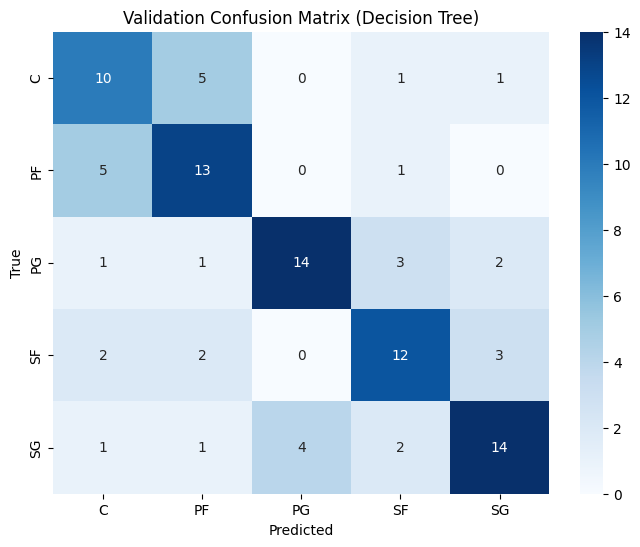

In [9]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns


X = df.drop(columns=['Pos'])
y = df['Pos']


scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)


X_train, X_val, y_train, y_val = train_test_split(X_scaled, y, test_size=0.2, stratify=y, random_state=0)

# Hyperparameter tuning for tree depth
param_grid = {'max_depth': range(1, 10)}
dtree = DecisionTreeClassifier(random_state=0)
grid = GridSearchCV(dtree, param_grid, cv=5)
grid.fit(X_train, y_train)

best_tree = grid.best_estimator_
print("Best max_depth:", grid.best_params_['max_depth'])

# Predict
y_train_pred = best_tree.predict(X_train)
y_val_pred = best_tree.predict(X_val)

# Accuracy
print("Training accuracy: {:.4f}".format(accuracy_score(y_train, y_train_pred)))
print("Validation accuracy: {:.4f}".format(accuracy_score(y_val, y_val_pred)))

# Confusion matrices
train_cm = confusion_matrix(y_train, y_train_pred, labels=best_tree.classes_)
val_cm = confusion_matrix(y_val, y_val_pred, labels=best_tree.classes_)

print("Training Confusion Matrix:\n", train_cm)
print("Validation Confusion Matrix:\n", val_cm)


plt.figure(figsize=(8,6))
sns.heatmap(val_cm, annot=True, fmt='d',
            xticklabels=best_tree.classes_,
            yticklabels=best_tree.classes_,
            cmap='Blues')
plt.title("Validation Confusion Matrix (Decision Tree)")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.show()


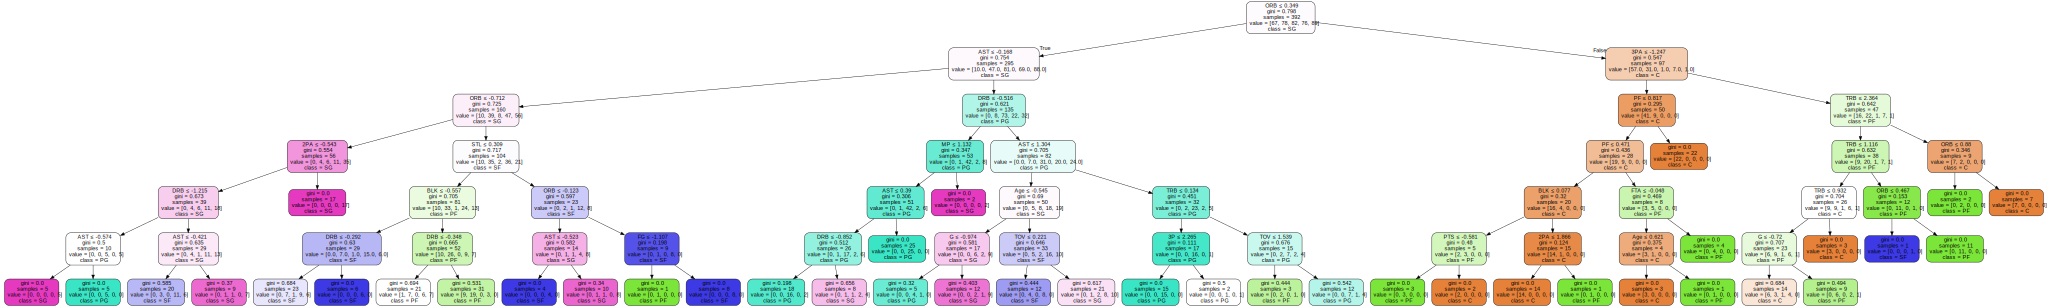

In [10]:
from sklearn.tree import export_graphviz
import graphviz


feature_names = X.columns

# Export tree
dot_data = export_graphviz(best_tree,
                          out_file=None,
                          feature_names=feature_names,
                          class_names=best_tree.classes_,
                          filled=True, rounded=True,
                          special_characters=True)

# Render with graphviz
graph = graphviz.Source(dot_data)
graph.render("decision_tree_nba", format="png", cleanup=True)
graph


TASK 2

In [11]:
import pandas as pd
from sklearn.metrics import accuracy_score, confusion_matrix

# Loading dummy test set
dummy_test = pd.read_csv('/content/dummy_test.csv')


feature_columns = X.columns

X_dummy = dummy_test[feature_columns]
y_dummy = dummy_test['Pos']


X_dummy_scaled = scaler.transform(X_dummy)

# --- KNN ---
y_dummy_knn = best_knn.predict(X_dummy_scaled)
print("KNN Dummy Test Accuracy: {:.4f}".format(accuracy_score(y_dummy, y_dummy_knn)))
print("KNN Dummy Test Confusion Matrix:\n", confusion_matrix(y_dummy, y_dummy_knn, labels=best_knn.classes_))

# --- SVM ---
y_dummy_svm = best_svm.predict(X_dummy_scaled)
print("SVM Dummy Test Accuracy: {:.4f}".format(accuracy_score(y_dummy, y_dummy_svm)))
print("SVM Dummy Test Confusion Matrix:\n", confusion_matrix(y_dummy, y_dummy_svm, labels=best_svm.classes_))

# --- Naive Bayes ---
y_dummy_nb = nb.predict(X_dummy_scaled)
print("Naive Bayes Dummy Test Accuracy: {:.4f}".format(accuracy_score(y_dummy, y_dummy_nb)))
print("Naive Bayes Dummy Test Confusion Matrix:\n", confusion_matrix(y_dummy, y_dummy_nb, labels=nb.classes_))

# --- Decision Tree ---
y_dummy_tree = best_tree.predict(X_dummy_scaled)
print("Decision Tree Dummy Test Accuracy: {:.4f}".format(accuracy_score(y_dummy, y_dummy_tree)))
print("Decision Tree Dummy Test Confusion Matrix:\n", confusion_matrix(y_dummy, y_dummy_tree, labels=best_tree.classes_))


KNN Dummy Test Accuracy: 0.5682
KNN Dummy Test Confusion Matrix:
 [[ 9  5  0  2  0]
 [ 1  9  2  5  2]
 [ 1  0 13  4  0]
 [ 0  5  0  9  2]
 [ 0  1  3  5 10]]
SVM Dummy Test Accuracy: 0.5795
SVM Dummy Test Confusion Matrix:
 [[14  1  1  0  0]
 [ 6  6  4  2  1]
 [ 0  1 16  0  1]
 [ 1  1  1  6  7]
 [ 0  2  6  2  9]]
Naive Bayes Dummy Test Accuracy: 0.5114
Naive Bayes Dummy Test Confusion Matrix:
 [[ 9  3  1  3  0]
 [ 1  5  3  6  4]
 [ 1  0 12  2  3]
 [ 0  1  0  9  6]
 [ 0  0  6  3 10]]
Decision Tree Dummy Test Accuracy: 0.5795
Decision Tree Dummy Test Confusion Matrix:
 [[12  2  0  0  2]
 [ 2  9  0  5  3]
 [ 0  0 12  2  4]
 [ 0  3  0  8  5]
 [ 0  2  3  4 10]]


TASK 3

In [12]:
from sklearn.model_selection import StratifiedKFold
from sklearn.tree import DecisionTreeClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score
import numpy as np


scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Preparing stratified 10-fold CV
skf = StratifiedKFold(n_splits=10, shuffle=True, random_state=0)


best_max_depth = 6
accuracies = []

for train_idx, test_idx in skf.split(X_scaled, y):
    X_train, X_test = X_scaled[train_idx], X_scaled[test_idx]
    y_train, y_test = y.iloc[train_idx], y.iloc[test_idx]

    model = DecisionTreeClassifier(max_depth=best_max_depth, random_state=0)
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    acc = accuracy_score(y_test, y_pred)
    accuracies.append(acc)

# Print fold-wise and average accuracy
for i, acc in enumerate(accuracies):
    print(f"Fold {i+1} Accuracy: {acc:.4f}")
print(f"Average 10-fold CV Accuracy: {np.mean(accuracies):.4f}")


Fold 1 Accuracy: 0.5102
Fold 2 Accuracy: 0.5102
Fold 3 Accuracy: 0.4898
Fold 4 Accuracy: 0.4490
Fold 5 Accuracy: 0.4898
Fold 6 Accuracy: 0.5714
Fold 7 Accuracy: 0.4898
Fold 8 Accuracy: 0.5918
Fold 9 Accuracy: 0.6122
Fold 10 Accuracy: 0.6327
Average 10-fold CV Accuracy: 0.5347


Improving Cross Validation Accuracy by using Random Forest

In [13]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import accuracy_score
import numpy as np

rf = RandomForestClassifier(n_estimators=100, random_state=0)
skf = StratifiedKFold(n_splits=10, shuffle=True, random_state=0)

fold_accuracies = []
for i, (train_idx, val_idx) in enumerate(skf.split(X_scaled, y)):
    X_train, X_val = X_scaled[train_idx], X_scaled[val_idx]
    y_train, y_val = y.iloc[train_idx], y.iloc[val_idx]
    rf.fit(X_train, y_train)
    preds = rf.predict(X_val)
    acc = accuracy_score(y_val, preds)
    fold_accuracies.append(acc)
    print(f"Fold {i+1} Accuracy: {acc:.4f}")

print(f"Average 10-fold CV Accuracy (Random Forest): {np.mean(fold_accuracies):.4f}")


Fold 1 Accuracy: 0.6122
Fold 2 Accuracy: 0.4898
Fold 3 Accuracy: 0.6531
Fold 4 Accuracy: 0.5102
Fold 5 Accuracy: 0.6122
Fold 6 Accuracy: 0.6735
Fold 7 Accuracy: 0.5714
Fold 8 Accuracy: 0.6327
Fold 9 Accuracy: 0.5714
Fold 10 Accuracy: 0.6122
Average 10-fold CV Accuracy (Random Forest): 0.5939
